In [52]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import seaborn as sns
import datetime
from lightgbm import LGBMRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from sklearn.metrics import r2_score


In [53]:
conn = sql.connect('Data/db/btc.db')
cursor = conn.cursor()
df_1d = pd.read_sql_query("SELECT * FROM btc_1d", conn)

fecha = df_1d['date'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_1d)

# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)

df_1d['date'] = fechas
df_1d.index = fechas

data_1d = df_1d.loc['2012-01-18 00:00:00':'2024-08-25 00:00:57']
inicio_train = '2012-01-18 00:00:00'
fin_train = '2023-07-15 00:00:00'
fin_validacion = '2024-07-15 00:00:00'

datos_train = data_1d.loc[:fin_train,:] # 2 años y 3 meses
datos_val = data_1d.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = data_1d.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")



Fechas train : 2012-01-18 00:00:57 --- 2023-07-14 00:00:57  (n=4196)
Fechas validacion : 2023-07-15 00:00:57 --- 2024-07-14 00:00:57  (n=366)
Fechas test : 2024-07-15 00:00:57 --- 2024-08-25 00:00:57  (n=42)


In [54]:
data_1d['mes'] = data_1d.index.month
data = pd.get_dummies(data_1d, columns=['reward', 'mes'], dtype=int)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_15520\3688054251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1d['mes'] = data_1d.index.month


In [55]:
exog = [column for column in data.columns if column.startswith(('reward', 'mes'))]
exog.extend(['countdown_halving'])

In [56]:
# Backtest forecaster con variables exógenas
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor        = LGBMRegressor(random_state=123, verbose=-1),
                 lags             = 1,
                 transformer_y    = None,
                 transformer_exog = None
             )
# Backtest test data 1 step
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data.loc[inicio_train:, 'close'],
                            exog               = data.loc[inicio_train:, exog],
                            initial_train_size = len(data.loc[inicio_train:fin_train,]),
                            fixed_train_size   = True,
                            steps              = 1,
                            refit              = True,
                            metric             = 'mean_absolute_percentage_error',
                            verbose            = False,
                            show_progress      = True
                        )

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\model_selection.py:548: LongTrainingWarning: The forecaster will be fit 408 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/408 [00:00<?, ?it/s]

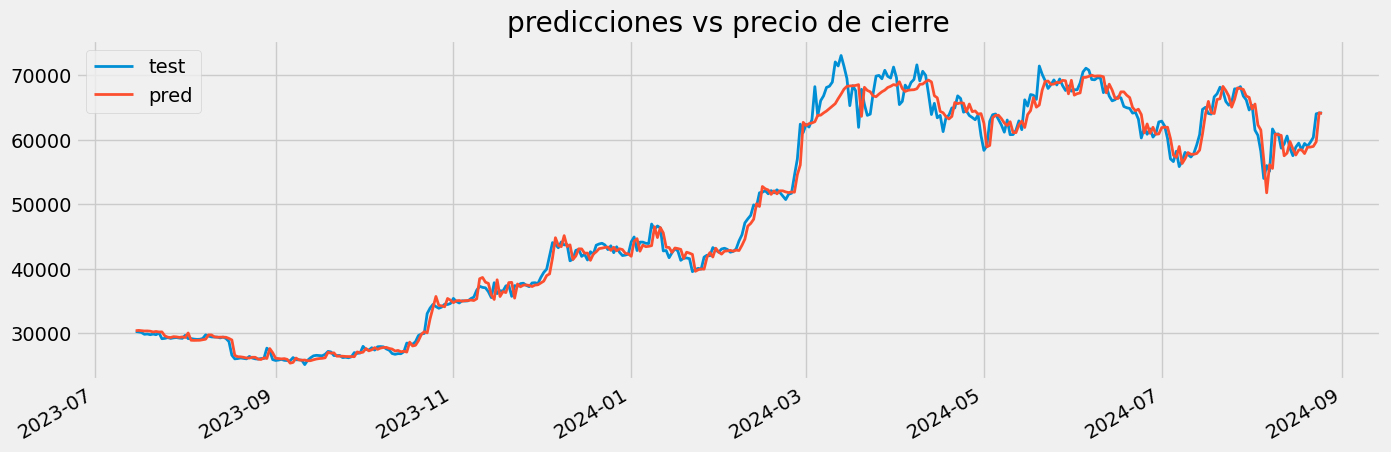

In [57]:
fig, ax = plt.subplots(figsize=(15,5))
data.loc[predicciones.index,'close'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs precio de cierre')
ax.legend()

In [58]:
print(metrica)
print(predicciones)

0.021224118833320853
                             pred
2023-07-15 00:00:57  30416.065844
2023-07-16 00:00:57  30466.394262
2023-07-17 00:00:57  30423.074640
2023-07-18 00:00:57  30372.175613
2023-07-19 00:00:57  30381.122687
...                           ...
2024-08-21 00:00:57  58879.941745
2024-08-22 00:00:57  58978.675914
2024-08-23 00:00:57  59706.352899
2024-08-24 00:00:57  64192.362573
2024-08-25 00:00:57  64084.414182

[408 rows x 1 columns]


In [59]:
# Create future dataframe
fecha_maxima = data.index.max()
fecha_maxima_timestamp = pd.Timestamp(fecha_maxima)
una_semana_mas = fecha_maxima_timestamp + pd.DateOffset(days=5)
future = pd.date_range(fecha_maxima,una_semana_mas)
print(future)

future_df = pd.DataFrame(index=future)
print(future_df)

DatetimeIndex(['2024-08-25 00:00:57', '2024-08-26 00:00:57',
               '2024-08-27 00:00:57', '2024-08-28 00:00:57',
               '2024-08-29 00:00:57', '2024-08-30 00:00:57'],
              dtype='datetime64[ns]', freq='D')
Empty DataFrame
Columns: []
Index: [2024-08-25 00:00:57, 2024-08-26 00:00:57, 2024-08-27 00:00:57, 2024-08-28 00:00:57, 2024-08-29 00:00:57, 2024-08-30 00:00:57]


In [60]:
data.loc[inicio_train:, 'close']

2012-01-18 00:00:57        5.90
2012-01-19 00:00:57        6.40
2012-01-20 00:00:57        6.50
2012-01-21 00:00:57        6.20
2012-01-22 00:00:57        6.30
                         ...   
2024-08-21 00:00:57    59627.99
2024-08-22 00:00:57    60375.84
2024-08-23 00:00:57    64037.24
2024-08-24 00:00:57    64157.01
2024-08-25 00:00:57    64169.99
Freq: D, Name: close, Length: 4604, dtype: float64

In [61]:
# Horizonte de predicción
horizonte = 6  # 1 valor actual + 5 valores hacia el futuro

# Asegúrate de que el forecaster está entrenado con todos los datos disponibles
forecaster.fit(y=data.loc[inicio_train:, 'close'], exog=data.loc[inicio_train:, exog])

# Realizar predicciones para las fechas futuras
#predicciones_futuras = forecaster.predict(steps=len(future_df), exog=future_df[exog])

# Creacion del dataframe con valores futuros para predicciones

In [62]:
# Crear DataFrame "esqueleto" de fechas futuras
fecha_maxima = data.index.max()
una_semana_mas = fecha_maxima + pd.DateOffset(days=6)
future = pd.date_range(fecha_maxima+ pd.DateOffset(days=1), una_semana_mas, freq='D')
future_df = pd.DataFrame(index=future)

# Crear un dataframe para las exógenas futuras
# Suponiendo que las variables exógenas se mantienen constantes en el futuro o tienen valores estimados
future_exog = pd.DataFrame(index=future)
# rellenar future_exog con valores estimados o supuestos de las variables exógenas
# Por ejemplo, si tienes variables dummy de meses, puedes replicar la lógica para las fechas futuras
future_exog['mes'] = future_exog.index.month
future_exog = pd.get_dummies(future_exog, columns=['mes'], dtype=int)
df_and_future = pd.concat([data, future_df])

df_and_future.drop(columns=['reward_3.125', 'reward_12.5', 'reward_25.0', 'reward_50.0', 'mes_1',
       'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9',
       'mes_10', 'mes_11', 'mes_12'],inplace=True)
df_and_future['mes'] = df_and_future.index.month

import Scripts.funciones as func
df_and_future = func.calcular_recompensa_y_cuenta_regresiva_1d(df_1d=df_and_future)
df_and_future = pd.get_dummies(df_and_future, columns=['reward', 'mes'], dtype=int)

In [71]:
print(df_and_future.index.is_unique)
print(df_and_future.index.hasnans)

True
False


In [74]:
fecha = df_and_future['index'][-1:].values[0]
ultima_fecha = pd.to_datetime(fecha)
# Número de días que quieres generar (ajusta este valor según tu necesidad)
num_dias = len(df_and_future)
# Crear una lista de fechas decrementando un día en cada iteración
fechas = pd.date_range(end=ultima_fecha, periods=num_dias)
df_and_future['index'] = fechas
df_and_future.index = fechas

In [76]:
df_and_future_recortado = df_and_future[-horizonte:]
# Generar predicciones
predicciones_futuras = forecaster.predict(steps=horizonte, exog=df_and_future_recortado[exog])

In [77]:
predicciones_futuras

2024-08-26 00:00:57    63535.424012
2024-08-27 00:00:57    62444.004734
2024-08-28 00:00:57    61590.130476
2024-08-29 00:00:57    61689.096042
2024-08-30 00:00:57    61689.096042
2024-08-31 00:00:57    61689.096042
Freq: D, Name: pred, dtype: float64

In [78]:
ultimos_valores_close = data['close'].iloc[-7:]

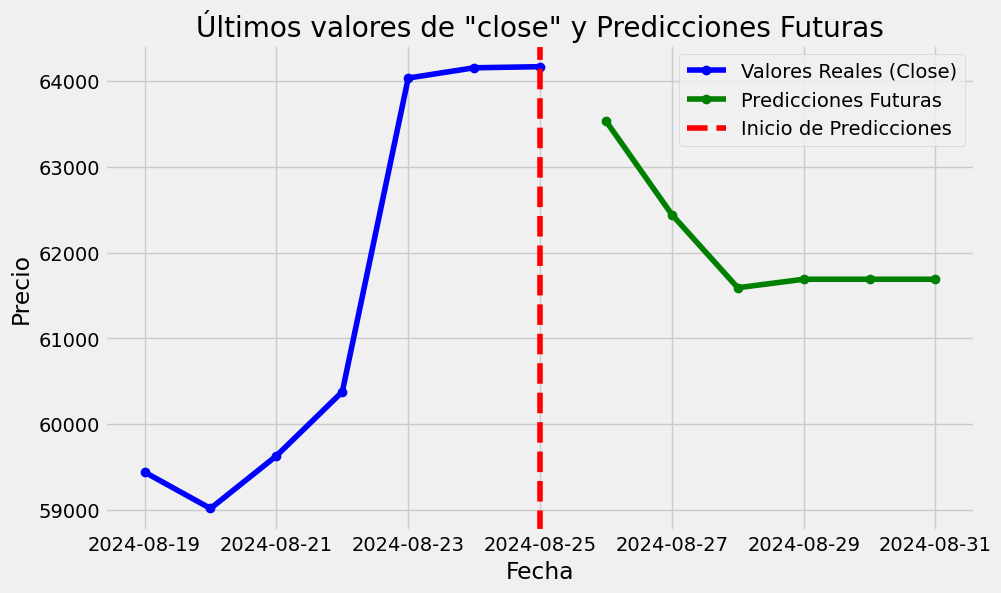

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(ultimos_valores_close.index, ultimos_valores_close.values, label='Valores Reales (Close)', marker='o', color='blue')
plt.plot(predicciones_futuras.index, predicciones_futuras.values, label='Predicciones Futuras', marker='o', color='green')

plt.axvline(x=ultimos_valores_close.index[-1], color='red', linestyle='--', label='Inicio de Predicciones')
plt.title('Últimos valores de "close" y Predicciones Futuras')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
# Mostrar el gráfico
plt.show()


A medida que intentemos predecir valores cada mes mas alejados del actual, es cada vez menos preciso. Considerando tambien que siempre existira una variacion aleatorio para cada paso.

In [80]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = data['close'],
    exog = data[exog],
    initial_train_size= len(data.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= False
)
metrica

  0%|          | 0/2 [00:00<?, ?it/s]

5605.728974545505

In [81]:
df_and_future_recortado.index

DatetimeIndex(['2024-08-26 00:00:57', '2024-08-27 00:00:57',
               '2024-08-28 00:00:57', '2024-08-29 00:00:57',
               '2024-08-30 00:00:57', '2024-08-31 00:00:57'],
              dtype='datetime64[ns]', freq='D')

In [82]:
df_and_future['close'].iloc[-10:]

2024-08-22 00:00:57    60375.84
2024-08-23 00:00:57    64037.24
2024-08-24 00:00:57    64157.01
2024-08-25 00:00:57    64169.99
2024-08-26 00:00:57         NaN
2024-08-27 00:00:57         NaN
2024-08-28 00:00:57         NaN
2024-08-29 00:00:57         NaN
2024-08-30 00:00:57         NaN
2024-08-31 00:00:57         NaN
Freq: D, Name: close, dtype: float64

In [83]:
# Paso 1: Predicciones sobre los últimos 5 valores conocidos
horizonte_pasos_conocidos = 6
ultimos_valores_close = df_and_future['close'].iloc[-(horizonte_pasos_conocidos + 6):-horizonte_pasos_conocidos]

#horizonte_pasos_conocidos = 5
#ultimos_valores_close = df_and_future['close'].iloc[-horizonte_pasos_conocidos -5:-1]

In [84]:
ultimos_valores_close

2024-08-20 00:00:57    59013.80
2024-08-21 00:00:57    59627.99
2024-08-22 00:00:57    60375.84
2024-08-23 00:00:57    64037.24
2024-08-24 00:00:57    64157.01
2024-08-25 00:00:57    64169.99
Freq: D, Name: close, dtype: float64

In [85]:

predicciones_ultimos_5 = forecaster.predict(steps=horizonte_pasos_conocidos, exog=df_and_future.iloc[-horizonte_pasos_conocidos:][exog])


In [86]:
# Combinar predicciones y valores reales
#valores_reales_y_predicciones = ultimos_valores_close.append(predicciones_ultimos_5)
# Concatenando las Series verticalmente
valores_reales_y_predicciones = pd.concat([ultimos_valores_close, predicciones_ultimos_5],axis=0)


In [87]:
valores_reales_y_predicciones

2024-08-20 00:00:57    59013.800000
2024-08-21 00:00:57    59627.990000
2024-08-22 00:00:57    60375.840000
2024-08-23 00:00:57    64037.240000
2024-08-24 00:00:57    64157.010000
2024-08-25 00:00:57    64169.990000
2024-08-26 00:00:57    63535.424012
2024-08-27 00:00:57    62444.004734
2024-08-28 00:00:57    61590.130476
2024-08-29 00:00:57    61689.096042
2024-08-30 00:00:57    61689.096042
2024-08-31 00:00:57    61689.096042
Freq: D, dtype: float64

In [98]:
predicciones_futuras

2024-08-26 00:00:57    63535.424012
2024-08-27 00:00:57    62444.004734
2024-08-28 00:00:57    61590.130476
2024-08-29 00:00:57    61689.096042
2024-08-30 00:00:57    61689.096042
2024-08-31 00:00:57    61689.096042
Freq: D, Name: pred, dtype: float64

In [103]:
predicciones_futuras

2024-08-26 00:00:57    63535.424012
2024-08-27 00:00:57    62444.004734
2024-08-28 00:00:57    61590.130476
2024-08-29 00:00:57    61689.096042
2024-08-30 00:00:57    61689.096042
2024-08-31 00:00:57    61689.096042
Freq: D, Name: pred, dtype: float64

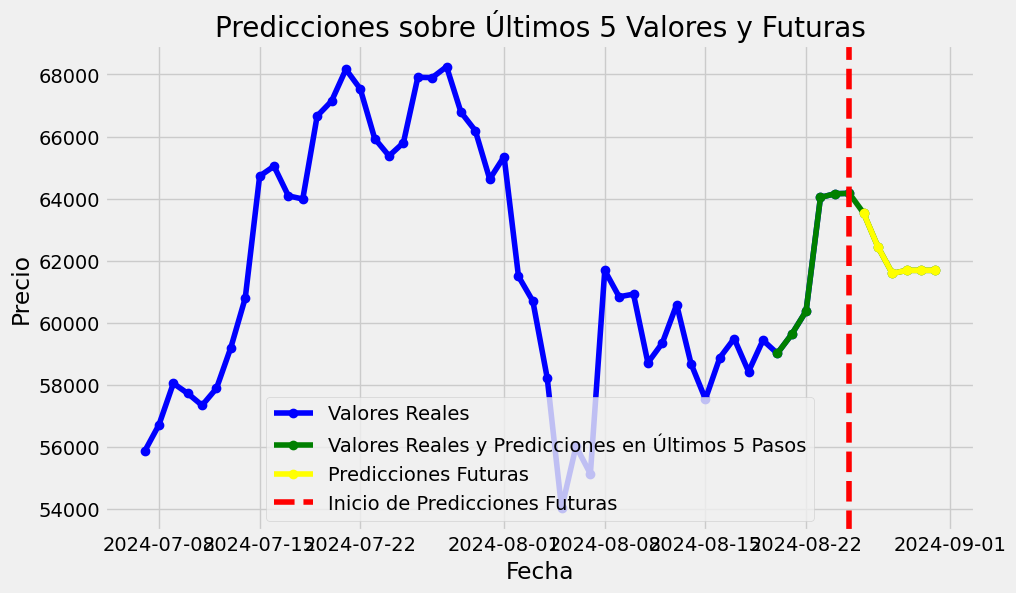

In [100]:

# Graficar los resultados
plt.figure(figsize=(10, 6))
# Graficar los últimos 50 valores conocidos y las predicciones sobre ellos
#plt.plot(valores_reales_y_predicciones.index, valores_reales_y_predicciones.values, label='Valores Reales y Predicciones en Últimos 5 Pasos', marker='o', color='blue')

# Graficar los últimos 50 valores conocidos y las predicciones sobre ellos
#plt.plot(valores_reales_y_predicciones.index, valores_reales_y_predicciones.values, label='Valores Reales y Predicciones en Últimos 5 Pasos', marker='o', color='blue')

plt.plot(data.index[-50:],data.close.values[-50:], label='Valores Reales', marker='o', color='blue')

# Graficar los últimos 50 valores conocidos y las predicciones sobre ellos
plt.plot(valores_reales_y_predicciones.index, valores_reales_y_predicciones.values, label='Valores Reales y Predicciones en Últimos 5 Pasos', marker='o', color='green')
# Graficar las predicciones futuras
plt.plot(predicciones_futuras.index, predicciones_futuras.values, label='Predicciones Futuras', marker='o', color='yellow')

# Personalizar el gráfico
plt.axvline(x=ultimos_valores_close.index[-1], color='red', linestyle='--', label='Inicio de Predicciones Futuras')
plt.title('Predicciones sobre Últimos 5 Valores y Futuras')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()